Solve the equation for the ansatz

In [237]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

import numpy as np
from scipy.optimize import least_squares

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

alpha_s = 2.3e-5
delta_s =3
a_p =2
g_m = np.array([4, 5, 6])
alpha_m = np.array([833,833,833])*0.00001
delta_m = np.array([0,0,0])

C1 = alpha_s - 1j*delta_s
C2 = -a_p**2

C = np.array([C1, C2])

D = g_m**2
E = alpha_m + 1j*delta_m


# Coefficent X^4
a = 1

# Coefficent X^3
b = E[0] + E[1] + E[2] - C[0]

# Coefficient X^2
c = (E[0]*E[1] + E[0]*E[2] + E[1]*E[2] - C[0]*E[0] - C[0]*E[1] - C[0]*E[2]) - C[1] * (D[0] + D[1] + D[2])

# Coefficient X
d = (E[0]*E[1]*E[2] - C[0]*E[0]*E[1] - C[0]*E[0]*E[2] - C[0]*E[1]*E[2]) - C[1] * (D[0]*(E[1]+E[2]) + D[1]*(E[0]+E[2]) + D[2]*(E[0]+E[1]))

# Terme constant
e = -C[0]*E[0]*E[1]*E[2] - C[1] * (D[0]*E[1]*E[2] + D[1]*E[0]*E[2] + D[2]*E[0]*E[1])

# On met les coefficients dans une liste, du plus haut degré au plus bas
coefficients = [a, b, c, d, e]
racines = np.roots(coefficients)


print(racines)

[-0.00379783-1.91139145e+01j -0.00450917+1.61139145e+01j
 -0.00833   +3.25136961e-10j -0.00833   -3.25136961e-10j]


Find heterodyne

[-1.91139145e+01+0.00379783j  1.61139145e+01+0.00450917j
  3.25136961e-10+0.00833j    -3.25136961e-10+0.00833j   ]


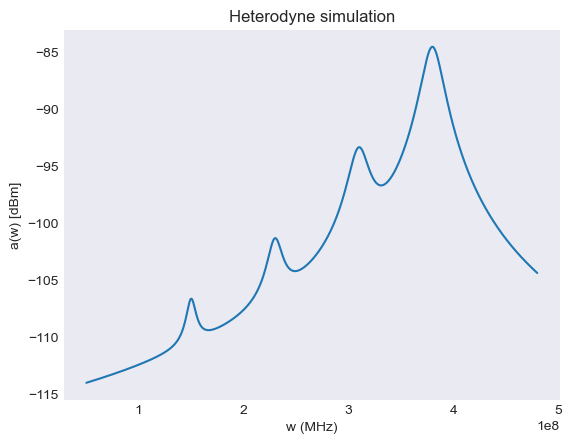

In [238]:
roots = racines/1j

print(roots)

#separate real and imaginary parts
q_re = np.real(roots)
q_im = np.imag(roots)

#q_re = np.array([1, 1.2, 1.6, 1.9])
#q_im = np.array([0.1, 0.1, 0.1, 0.1])


A = []

for i in range(len(roots)):
    A.append(C[1]*np.sum(D)/(1-C[1]*np.sum(D/(1j*roots[i]*E))))

A = np.array(A)

#here we just try values of A, q_im, q_re to match our experiment. Then will find the parameters of the physical system from that.

A = np.array([0.1, 0.3, 1.1, 3.3])*180
q_re = np.array([1.5, 2.3, 3.1, 3.8])*1e8
q_im = np.array([0.1, 0.15, 0.2, 0.2])*0.5*1e8

# create the lorentzian function a(w) = sum of |Ak|^2/(w-q_re)^2+q_im^2
def lorentzian(w):
    a = 0
    for k in range(len(A)):
        a += np.abs(A[k])**2 / ((w - q_re[k])**2 + q_im[k]**2)
        a_dbm = 10 * np.log10(a + 1e-30)
    return a_dbm

#plot the lorentzian function

padding = 10e7  # extra space around peaks
w_min = np.min(q_re) - padding
w_max = np.max(q_re) + padding
w = np.linspace(w_min, w_max, 1000)

plt.plot(w,lorentzian(w))  # 1 mW = 1e-3 W
plt.xlabel('w (MHz)')
plt.ylabel('a(w) [dBm]')
plt.title('Heterodyne simulation')
plt.grid()
plt.show()

Fit heterodyne to our data

Fitted A: [292.98436285  81.01690903 113.39773109 349.77112164]
Fitted q_re: [9.36838099e+07 2.26086383e+08 3.03246237e+08 3.74673715e+08]
Fitted q_im: [1.34876597e+08 1.34947285e+07 1.18340177e+07 4.34377078e+06]


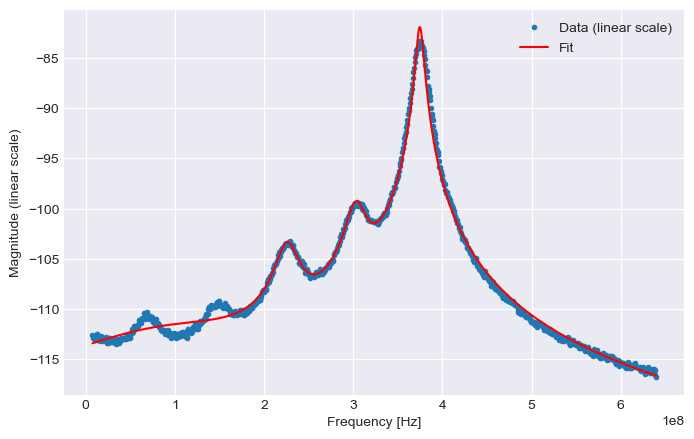

In [239]:


# Your Lorentzian sum function rewritten to take parameters as a flat array
def lorentzian_fit(w, *params):
    # params contains [A0, A1, ..., q_re0, q_re1, ..., q_im0, q_im1, ...]
    n = len(params) // 3
    A = np.array(params[0:n])
    q_re = np.array(params[n:2*n])
    q_im = np.array(params[2*n:3*n])
    
    a = np.zeros_like(w, dtype=float)
    for k in range(n):
        a += (A[k]**2) / ((w - q_re[k])**2 + q_im[k]**2)

    # Convert linear to dBm, add a tiny epsilon to avoid log(0)
    a_dbm = 10 * np.log10(a + 1e-30)
    return a_dbm

# Load your data CSV (assuming tab-separated or whitespace-separated)
df_ = pd.read_csv(r"D:\Imperial\Master thesis\data\Book1.csv", sep=',')

start = 1*len(df_)//100
end = 80*len(df_)//100


frequency_data = df_.iloc[start:end, 0].to_numpy(dtype=float)  # Frequency [Hz]
magnitude_data = df_.iloc[start:end, 1].to_numpy(dtype=float)  # Magnitude [dBm]



# Initial guess (flatten all parameters into one array)
initial_guess = np.concatenate([A, q_re, q_im])

# Fit with curve_fit
popt, pcov = curve_fit(lorentzian_fit, frequency_data, magnitude_data, p0=initial_guess)

# Extract fitted parameters
n = len(A)
A_fit_hetero = popt[0:n]
q_re_fit_hetero = popt[n:2*n]
q_im_fit_hetero = popt[2*n:3*n]

print("Fitted A:", A_fit_hetero)
print("Fitted q_re:", q_re_fit_hetero)
print("Fitted q_im:", q_im_fit_hetero)

plt.figure(figsize=(8,5))
plt.plot(frequency_data, magnitude_data, label='Data (linear scale)', marker='.', linestyle='None')
plt.plot(frequency_data, lorentzian_fit(frequency_data, *popt), label='Fit', color='red')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude (linear scale)')
plt.legend()
plt.show()

Just take the data to have same axis for g2 simu and real

In [240]:
# ---------- data ----------

df = pd.read_csv(r"D:\Imperial\Master thesis\data\tx_.1_ns_over_weekend_1.csv")  # tab-separated file

average = df['Channel 1!!!_y'].head(100).mean()  

df['Channel 1!!!_y'] = df['Channel 1!!!_y']/average   #because the data is not normalized !

start = len(df)//2 + 50
end = 60*len(df)//100

euh = end - start

start-=euh





tau_data = df.iloc[start: end, 0].to_numpy(dtype=float)  # first column
g2_data = df.iloc[start: end, 1].to_numpy(dtype=float)   # second column

#center

tau_data-=3050

#rescale x

tau_data = tau_data/25

Find g2

A_g2: [0.75124196 0.20773566 0.29076341 0.89684903]
q_re_g2: [0.9368381  2.26086383 3.03246237 3.74673715]
q_im_g2: [1.34876597 0.13494728 0.11834018 0.04343771]
min: 1.0200197848007166
max: 1.4859563302200325


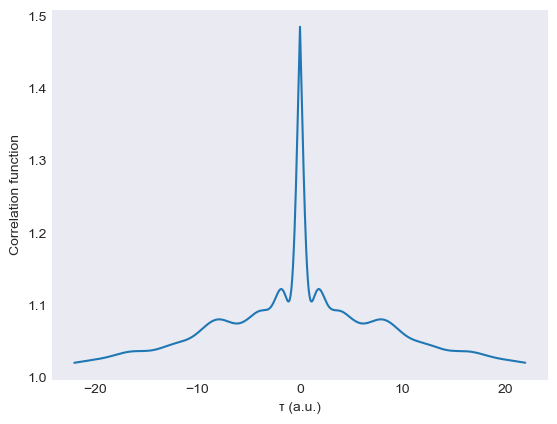

In [241]:
#Find g2 now


# A_g2 = np.array([2, 1, 1, 0])
# q_re_g2 = np.array([0.1, 0.2, 3, 3.1])  
# q_im_g2 = np.array([0.1, 0.4, 0.5, 0.2])

#A = np.array([0.1, 0.3, 1.1, 3.3])*180
# q_re = np.array([1.5, 2.3, 3.1, 3.8])*1e8
# q_im = np.array([0.1, 0.15, 0.2, 0.2])*0.5*1e8

A_g2 = A_fit_hetero*1e-2/3.9
q_re_g2 = q_re_fit_hetero*1e-8 #I have to put back the frequency values in Hz that's weird, actually I have to scale everything...
q_im_g2 = q_im_fit_hetero*1e-8

# A_g2 = A_fit_g2
# q_re_g2 = q_re_fit_g2
# q_im_g2 = q_im_fit_g2


print("A_g2:",A_g2)
print("q_re_g2:",q_re_g2)
print("q_im_g2:",q_im_g2)

def g2(tau):
    tau = np.atleast_1d(tau)
    
    S1 = np.sum(
        (A_g2**2)[:, None] *
        np.exp(1j * q_re_g2[:, None] * tau[None, :]) *
        np.exp(-q_im_g2[:, None] * np.abs(tau)[None, :]),
        axis=0
    )
    S2 = np.sum(A_g2)
    res=S1/S2
    raw_g2 = 1 + np.real(res)**2 + np.imag(res)**2

    # Normalize so that min = 1 and max = 2 (actually not needed with the right parameters, it's still a bit weird)
    # min_val = np.min(raw_g2)
    # max_val = np.max(raw_g2)
    # normalized_g2 = 1 + (raw_g2 - min_val) / (max_val - min_val)

    return raw_g2
    #return normalized_g2



tau = np.linspace(-50, 50, 1000)
tau =  tau_data   #let's take the same tau as below !

print("min:",np.min(g2(tau)))
print("max:",np.max(g2(tau)))   #to avoid confusion with the axis scaling

plt.plot(tau, g2(tau))
plt.xlabel('τ (a.u.)')
plt.ylabel('Correlation function')
#plt.title('g2')
plt.grid()
plt.show()

David's method for calculating g2

In [242]:
# eps = 1e-15
# #first take our individual a_s

# def stoke_modes(z, q_re, q_im):
#     z = np.atleast_1d(z)
#     q_re = np.array(q_re)
#     q_im = np.array(q_im)
#     return np.exp(1j * (q_re[:, None] + 1j * q_im[:, None]) * z[None, :])


# z = np.linspace(0,50,1000)

# a = stoke_modes(z,q_re,q_im)

# #a = stoke_modes(z,q_re_fit,q_im_fit)


# def compute_g1_vs_tau(a1, a2):
#     """
#     Computes the first-order temporal coherence g^(1)(tau).
#     """
#     N = len(a1)
#     taus = np.arange(-N + 1, N)
#     g1 = np.zeros(len(taus), dtype=complex)
#     norm = np.sqrt(np.mean(np.abs(a1)**2) * np.mean(np.abs(a2)**2)) + eps
#     for i, tau in enumerate(taus):
#         if tau >= 0:
#             x1 = a1[:N - tau]
#             x2 = a2[tau:]
#         else:
#             x1 = a1[-tau:]
#             x2 = a2[:N + tau]
#         g1[i] = np.mean(np.conj(x1) * x2) / norm
#     return taus, g1

# def compute_g2_vs_tau(a1, a2):
#     """
#     Computes the second-order temporal coherence g^(2)(tau).
#     """
#     N = len(a1)
#     I1 = np.abs(a1)**2
#     I2 = np.abs(a2)**2
#     taus = np.arange(-N + 1, N)
#     g2 = np.zeros(len(taus), dtype=float)
#     norm = np.mean(I1) * np.mean(I2) + eps
#     for i, tau in enumerate(taus):
#         if tau >= 0:
#             x1 = I1[:N - tau]
#             x2 = I2[tau:]
#         else:
#             x1 = I1[-tau:]
#             x2 = I2[:N + tau]
#         g2[i] = np.mean(x1 * x2) / norm
#     return taus, g2

# dz = z[1] - z[0]

# # --- CALCULATIONS ---
# a1 = a[0]
# a2 = a[1]
# a3 = a[2]
# a_total = a1 + a2 + a3

# # First-order coherence
# taus, g1_11 = compute_g1_vs_tau(a1, a1); _, g1_22 = compute_g1_vs_tau(a2, a2)
# _, g1_33 = compute_g1_vs_tau(a3, a3); _, g1_12 = compute_g1_vs_tau(a1, a2)
# _, g1_13 = compute_g1_vs_tau(a1, a3); _, g1_23 = compute_g1_vs_tau(a2, a3)

# # Second-order coherence
# _, g2_11 = compute_g2_vs_tau(a1, a1); _, g2_22 = compute_g2_vs_tau(a2, a2)
# _, g2_33 = compute_g2_vs_tau(a3, a3); _, g2_total = compute_g2_vs_tau(a_total, a_total)


# z_to_ns = 12.5 / np.pi  # Conversion factor from z-units to nanoseconds


# delay_ns = (taus * dz) * z_to_ns

# # --- PLOTTING ---
# plt.style.use('seaborn-v0_8-darkgrid')

# # g1 plot
# fig1, axs1 = plt.subplots(3, 2, figsize=(12, 15), sharex=True, sharey=True)
# fig1.suptitle('First-Order Coherence |g$^{(1)}$(τ)|', fontsize=16)
# axs1[0, 0].plot(delay_ns, np.abs(g1_11)); axs1[0, 0].set_title('Auto: g$^{(1)}$(a1, a1)')
# axs1[1, 0].plot(delay_ns, np.abs(g1_22)); axs1[1, 0].set_title('Auto: g$^{(1)}$(a2, a2)')
# axs1[2, 0].plot(delay_ns, np.abs(g1_33)); axs1[2, 0].set_title('Auto: g$^{(1)}$(a3, a3)')
# axs1[0, 1].plot(delay_ns, np.abs(g1_12)); axs1[0, 1].set_title('Cross: g$^{(1)}$(a1, a2)')
# axs1[1, 1].plot(delay_ns, np.abs(g1_13)); axs1[1, 1].set_title('Cross: g$^{(1)}$(a1, a3)')
# axs1[2, 1].plot(delay_ns, np.abs(g1_23)); axs1[2, 1].set_title('Cross: g$^{(1)}$(a2, a3)')
# for ax in axs1.flat:
#     ax.set(xlabel='Delay τ (ns)', ylabel='|g$^{(1)}$(τ)|'); ax.grid(True)

# # g2 plot
# fig2, axs2 = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
# fig2.suptitle('Second-Order Coherence g$^{(2)}$(τ)', fontsize=16)
# axs2[0, 0].plot(delay_ns, g2_11); axs2[0, 0].set_title('Auto: g$^{(2)}$(a1, a1)')
# axs2[0, 1].plot(delay_ns, g2_22); axs2[0, 1].set_title('Auto: g$^{(2)}$(a2, a2)')
# axs2[1, 0].plot(delay_ns, g2_33); axs2[1, 0].set_title('Auto: g$^{(2)}$(a3, a3)')
# axs2[1, 1].plot(delay_ns, g2_total); axs2[1, 1].set_title('Auto: g$^{(2)}$(a_total, a_total)')
# for ax in axs2.flat:
#     ax.set(xlabel='Delay τ (ns)', ylabel='g$^{(2)}$(τ)|'); ax.grid(True)
# axs2[0,0].set_xlim(-20, 20)

# plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

Fit the g2 to our data

A initial : [0.75124196 0.20773566 0.29076341 0.89684903]
q_re initial : [0.9368381  2.26086383 3.03246237 3.74673715]
q_im initial : [1.34876597 0.13494728 0.11834018 0.04343771]
Fitted parameters:
A fitted: [0.26998446 0.30064009 0.76677087 0.88085197]
q_re fitted: [-562.42127251 -561.2414228  -560.17617271 -559.97415746]
q_im fitted: [0.33273402 0.1101626  0.18394621 0.16993407]


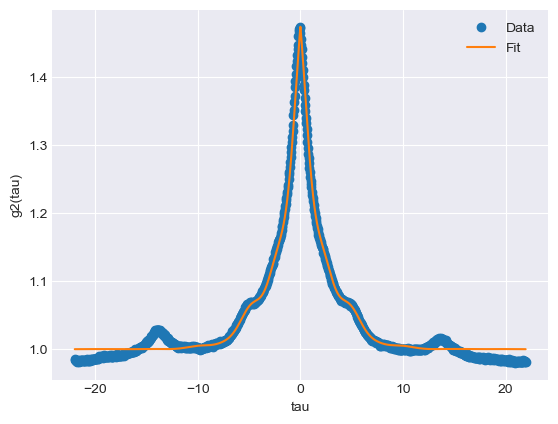

In [243]:
#now fitting a curve



# ---------- Model ----------
def g2_model(tau, *params):
    n_terms = 4  # number of Lorentzians
    A_     = np.array(params[0:n_terms])
    q_re_  = np.array(params[n_terms:2*n_terms])
    q_im_  = np.array(params[2*n_terms:3*n_terms])
    
    S1 = np.sum(
        (A_**2)[:, None] *
        np.exp(1j * q_re_[:, None] * tau[None, :]) *
        np.exp(-q_im_[:, None] * np.abs(tau)[None, :]),
        axis=0
    )
    S2 = np.sum(A_)
    res = S1 / S2
    return 1 + np.real(res)**2 + np.imag(res)**2



# ---------- Fit ----------

A_ini = A_fit_hetero*1e-2/3.9
q_re_ini = q_re_fit_hetero*1e-8 #I have to put back the frequency values in Hz that's weird, actually I have to scale everything...
q_im_ini = q_im_fit_hetero*1e-8


p0 = [A_ini,q_re_ini,q_im_ini]  # initial guesses

print("A initial :",A_ini)
print("q_re initial :",q_re_ini)
print("q_im initial :",q_im_ini)

# ---------- Fit ----------
popt, pcov = curve_fit(lambda t, *p: g2_model(t, *p),
                       tau_data, g2_data, p0=p0)

# ---------- Results ----------

A_fit_g2 = popt[0:4]
q_re_fit_g2 = popt[4:8]
q_im_fit_g2 = popt[8:12]

print("Fitted parameters:")
print("A fitted:",A_fit_g2)
print("q_re fitted:",q_re_fit_g2)
print("q_im fitted:",q_im_fit_g2)

plt.plot(tau_data, g2_data, 'o', label='Data')
plt.plot(tau_data, g2_model(tau_data, *popt), '-', label='Fit')
plt.xlabel('tau')
plt.ylabel('g2(tau)')
plt.legend()
plt.show()

find the parameters once we have good q_re, q_im and Aq

In [244]:


# Expected roots (replace with your estimates)
expected_roots = (q_re_fit_hetero + 1j*q_im_fit_hetero)*1j  # Example

# Initial guesses (split into real and imaginary parts)
C1_real, C1_imag = 2.3e-5, -3  # C1 = C1_real + 1j*C1_imag
C2_real, C2_imag = -4, 0        # C2 is real (C2_imag = 0)
D_initial = np.array([4, 5, 6])  # D is real
E_real = np.array([0.0833, 0.0833, 0.0833])  # Real part of E
E_imag = np.array([0, 0, 0])  # Imaginary part of E (delta_m=0)

# Pack all real-valued parameters into a single array
initial_params = np.concatenate([
    [C1_real, C1_imag, C2_real, C2_imag],  # C components
    D_initial,  # D is real
    E_real, E_imag  # E components
])

def compute_roots(params):
    # Unpack parameters
    C1_real, C1_imag, C2_real, C2_imag = params[:4]
    D = params[4:7]
    E_real = params[7:10]
    E_imag = params[10:13]
    
    # Reconstruct complex numbers
    C1 = C1_real + 1j * C1_imag
    C2 = C2_real + 1j * C2_imag
    C = np.array([C1, C2])
    E = E_real + 1j * E_imag
    
    # Compute polynomial coefficients
    a = 1
    b = E[0] + E[1] + E[2] - C[0]
    c = (E[0]*E[1] + E[0]*E[2] + E[1]*E[2] - C[0]*(E[0]+E[1]+E[2])) - C[1]*(D[0]+D[1]+D[2])
    d = (E[0]*E[1]*E[2] - C[0]*(E[0]*E[1] + E[0]*E[2] + E[1]*E[2])) - C[1]*(D[0]*(E[1]+E[2]) + D[1]*(E[0]+E[2]) + D[2]*(E[0]+E[1]))
    e = -C[0]*E[0]*E[1]*E[2] - C[1]*(D[0]*E[1]*E[2] + D[1]*E[0]*E[2] + D[2]*E[0]*E[1])
    
    coefficients = [a, b, c, d, e]
    computed_roots = np.roots(coefficients)
    return computed_roots

def cost_function(params):
    computed_roots = compute_roots(params)
    # Match computed roots to expected roots (absolute difference)
    error = np.abs(computed_roots - expected_roots)
    return error.flatten()

# Run least-squares optimization (using 'trf' instead of 'lm')
result = least_squares(cost_function, initial_params, method='trf')  # Trust Region Reflective

# Extract optimized parameters
optimized_C1 = result.x[0] + 1j * result.x[1]
optimized_C2 = result.x[2] + 1j * result.x[3]
optimized_D = result.x[4:7]
optimized_E = result.x[7:10] + 1j * result.x[10:13]


#now we find the parameters of the physical system : 
_alpha_s = result.x[0]   
_delta_s =-result.x[1]
_a_p =np.sqrt(optimized_C2)
_g_m = np.sqrt(result.x[4:7])
_alpha_m = result.x[7:10]
_delta_m = result.x[10:13]

#in theory
# alpha_s = 2.3e-5
# delta_s =3
# a_p =2
# g_m = np.array([4, 5, 6])
# alpha_m = np.array([833,833,833])*0.00001
# delta_m = np.array([0,0,0])


print("_alpha_s:",_alpha_s)
print("_delta_s:",_delta_s)
print("_a_p:",_a_p)
print("_g_m:",_g_m)
print("_alpha_m:",_alpha_m)
print("_delta_m:",_delta_m)



# Verify the roots
final_roots = compute_roots(result.x)
print("Final roots:", final_roots)
print("Expected roots:", expected_roots)

_alpha_s: 2.2999999999137287e-05
_delta_s: -2.7086004409752444
_a_p: (0.35753287590484983-2.182349892983292j)
_g_m: [1.16111023 1.74417402 2.29970877]
_alpha_m: [0.0833 0.0833 0.0833]
_delta_m: [ 0.          0.         -9.52998233]
Final roots: [-0.91273442+1.25645872e+01j  0.91467207-4.14043896e+00j
 -0.16851466+3.81443454e+00j -0.0833    +3.46334999e-18j]
Expected roots: [-1.34876597e+08+9.36838099e+07j -1.34947285e+07+2.26086383e+08j
 -1.18340177e+07+3.03246237e+08j -4.34377078e+06+3.74673715e+08j]
